In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import scipy as sp
import statsmodels.api as sm

## 0) Data Load

In [2]:
train_16 = pd.read_csv('train_2016_v2.csv',parse_dates=['transactiondate'],dtype={'parcelid':int})

In [3]:
prop_16 = pd.read_csv('properties_2016.csv',dtype={'fireplaceflag':object, 'taxdelinquencyflag':object, 'fireplaceflag':object, 'propertyzoningdesc':object, 'propertycountylandusecode':object, 'hashottuborspa':object})

In [4]:
train_df1 = pd.merge(train_16,prop_16,on='parcelid', how ='left')

In [5]:
train_df = train_df1.copy()

train_17 = pd.read_csv('train_2017.csv',parse_dates=['transactiondate'])

prop_17 = pd.read_csv('properties_2017.csv')

train_df2 = pd.merge(train_17,prop_17,on='parcelid', how ='left')

train_df = pd.concat([train_df1,train_df2])

train_df.head()

# 1) Analysis Outer-Feature

## 1.1) Overview the Outer-feature data

- 'architecturalstyletypeid'
- 'buildingqualitytypeid'
- 'buildingclasstypeid'
- 'decktypeid'
- 'numberofstories'
- 'storytypeid'
- 'typeconstructiontypeid'
- 'unitcnt'
- 'yardbuildingsqft17'
- 'yardbuildingsqft26'
- 'yearbuilt'

outer feature는 총 12개의 컬럼으로 이뤄져 있고, 분류 기준은 집의 전체적인 구조(structure)적인 부분에서 관찰될 수 있는 특징에 관한 것입니다.

In [6]:
outer_feature=[
'건축 양식 아이디',
'건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)',
'건물 뼈대에 어떤 타입의 재료가 쓰였는지',
'집 마당 부근에 있는 갑판(테라스같은 것을 의미)',
'집의 층 수 (story or level이라고 표현한다.)',
'집의 층 수 (story or level이라고 표현한다.)',
'주택 건설에 사용 된 건축 자재의 유형',
'구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)',
'주거지가 지어진 해']
len(outer_feature)

9

In [7]:
outer_feature_col = [
'architecturalstyletypeid',
'buildingqualitytypeid',
'buildingclasstypeid',
'decktypeid',
'numberofstories',
'storytypeid',
'typeconstructiontypeid',
'unitcnt',
'yearbuilt']
len(outer_feature_col)

9

In [8]:
outer_df = pd.DataFrame(columns=['name','feature'])
outer_df.name = outer_feature_col
outer_df.feature = outer_feature
outer_df

,name,feature
0,architecturalstyletypeid,건축 양식 아이디
1,buildingqualitytypeid,건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)
2,buildingclasstypeid,건물 뼈대에 어떤 타입의 재료가 쓰였는지
3,decktypeid,집 마당 부근에 있는 갑판(테라스같은 것을 의미)
4,numberofstories,집의 층 수 (story or level이라고 표현한다.)
5,storytypeid,집의 층 수 (story or level이라고 표현한다.)
6,typeconstructiontypeid,주택 건설에 사용 된 건축 자재의 유형
7,unitcnt,"구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)"
8,yearbuilt,주거지가 지어진 해


## 1.2) Datatype of Columns

In [9]:
print(train_df[outer_feature_col].dtypes,end='\n\n'),
print('Number of outer_feature_col:  {}'.format(len(outer_feature_col)))

architecturalstyletypeid    float64
buildingqualitytypeid       float64
buildingclasstypeid         float64
decktypeid                  float64
numberofstories             float64
storytypeid                 float64
typeconstructiontypeid      float64
unitcnt                     float64
yearbuilt                   float64
dtype: object

Number of outer_feature_col:  9


outer-feature의 자료형은 모두 float형입니다.

## 1.3) Individual columns' feature analysis

### scatter plot about numerical data

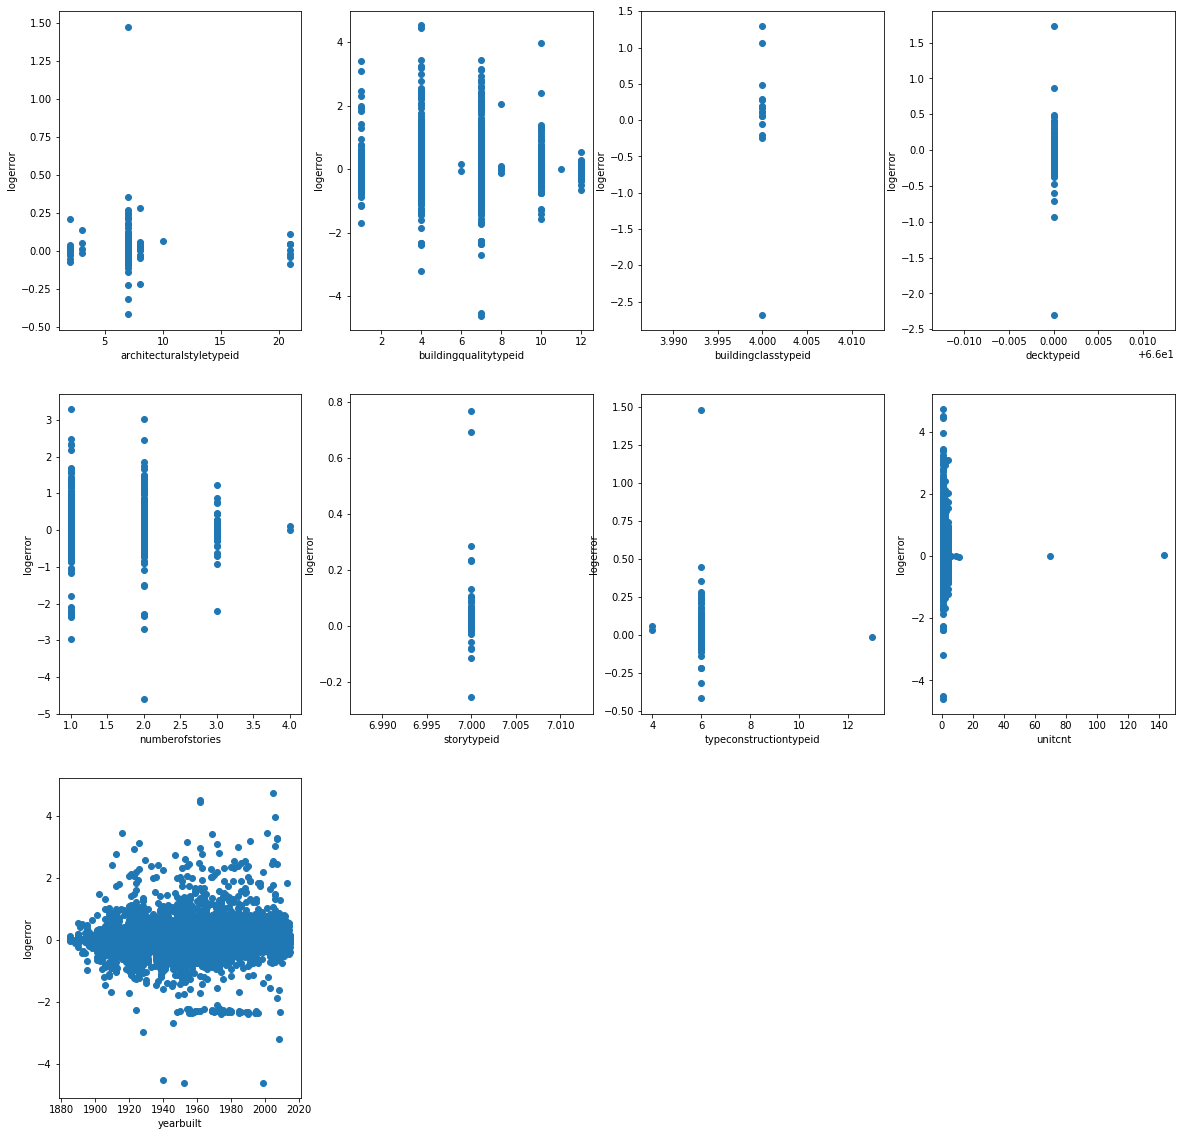

In [10]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(outer_feature_col):
    plt.subplot(3,4,idx+1)
    plt.scatter(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- 자료형은 numerical data로 나왔지만 scatter plot으로 봤을 때, 분포도가 continuous 하지 않고 discrete한 데이터라는 것을 알 수 있다.
- discrete data는 float형으로 이뤄진 category를 가지고 있다고 할 수 있고, 이는 후에 나올 data cleaning에도 유의하게 보아야 할 정보다.
- 이러한 자료들을 value_counts 명령어로 확인해보겠다. discrete 한지 안한지에 대해서 기준을 두는데, 그 기준은 category가 40개를 넘지 않는 것으로 하겠다.
- 위의 조건을 만족하는 컬럼을 discrete_outer_col이라는 리스트에 넣고 이 컬럼들을 시각화해보겠다.

In [11]:
discrete_outer_col = []
for idx,col in enumerate(outer_feature_col):
    if len(train_df[col].value_counts())<40:
        print(train_df[col].value_counts())
        discrete_outer_col.append(col)
len(discrete_outer_col)

7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64
7.0     29310
4.0     23839
1.0      2627
10.0     1461
12.0      119
8.0         5
6.0         2
11.0        1
Name: buildingqualitytypeid, dtype: int64
4.0    16
Name: buildingclasstypeid, dtype: int64
66.0    658
Name: decktypeid, dtype: int64
1.0    12016
2.0     8044
3.0      508
4.0        2
Name: numberofstories, dtype: int64
7.0    43
Name: storytypeid, dtype: int64
6.0     296
4.0       2
13.0      1
Name: typeconstructiontypeid, dtype: int64
1.0      54503
2.0       2354
4.0        871
3.0        619
6.0          1
5.0          1
9.0          1
11.0         1
143.0        1
70.0         1
Name: unitcnt, dtype: int64


8

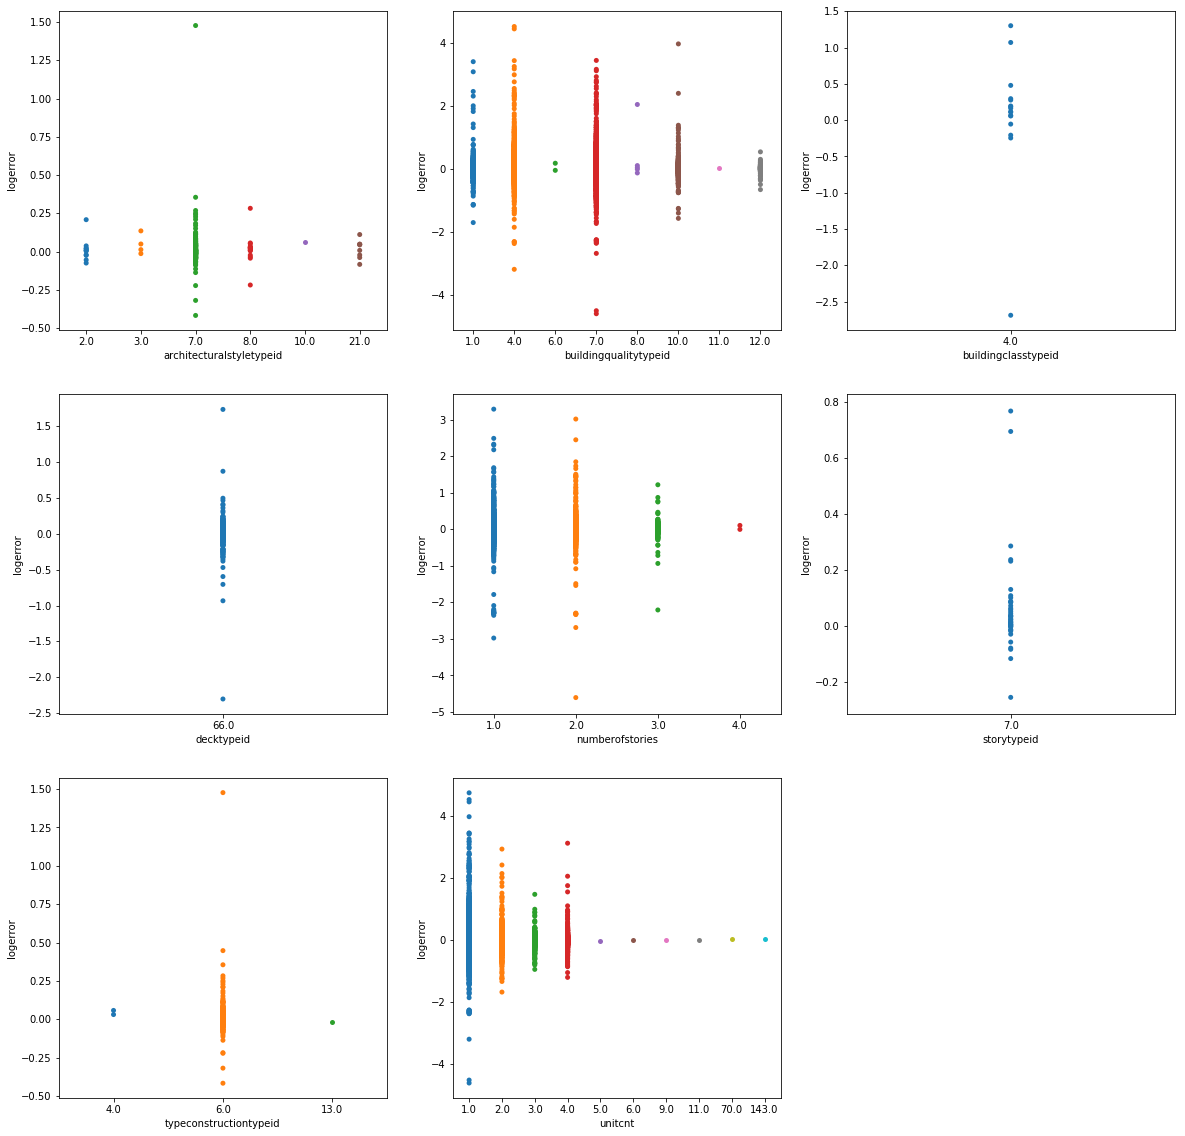

In [12]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_outer_col):
    plt.subplot(3,3,idx+1)
    sns.stripplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

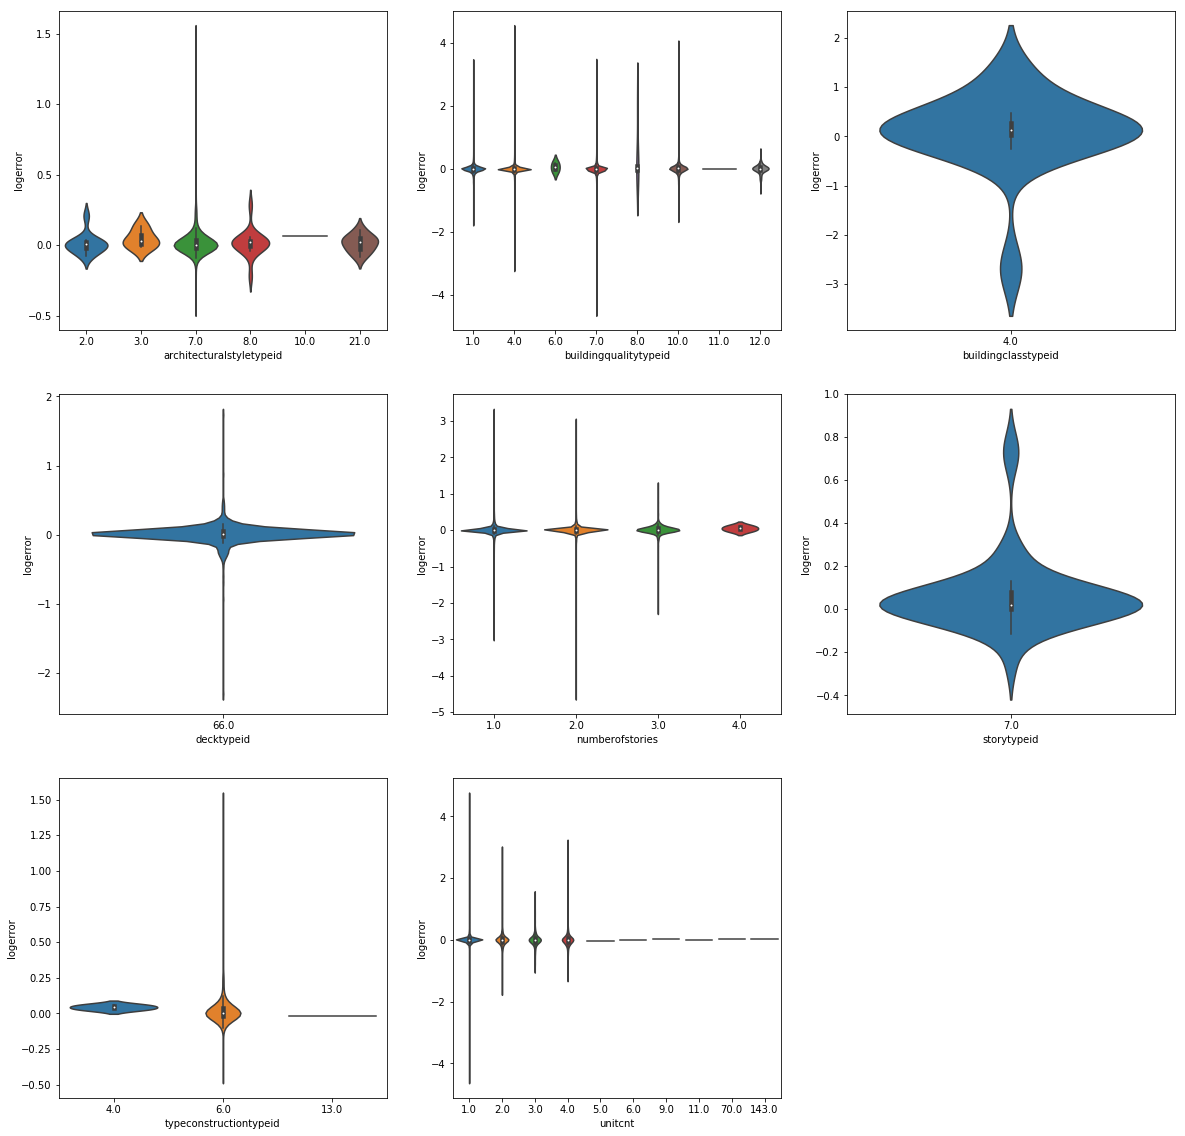

In [13]:
plt.figure(figsize=(20,20))
for idx,col in enumerate(discrete_outer_col):
    plt.subplot(3,3,idx+1)
    sns.violinplot(train_df[col],train_df.logerror)
    plt.xlabel(col)
    plt.ylabel('logerror')
plt.show()

- discrete data 에 대해서 plot을 그려보니, 카테고리 자체가 1개인 컬럼이 존재한다는 것과 multiple(2개 이상)한 카테고리를 가지고 있지만, 그 분포가 치우쳐져있는 컬럼이 있다는 것을 파악할 수 있다.
- 이와 같은 특성은 곧 실시한 data cleaning에서 감안해야 할 부분이다.

In [14]:
print(train_df.typeconstructiontypeid.value_counts())
print(train_df.architecturalstyletypeid.value_counts())

6.0     296
4.0       2
13.0      1
Name: typeconstructiontypeid, dtype: int64
7.0     221
8.0      16
2.0      11
21.0      8
3.0       4
10.0      1
Name: architecturalstyletypeid, dtype: int64


## 1.4)Analysis discrete variable
- BuildingClassTypeID column의 category는 4번 하나만 존재한다. `Buildings having wood or wood and steel frames` 의 특성만을 가지고 있고 이는 Data cleaning 과정에서 고려할 사항이다.
- TypeconstructiontypeID column의 cateory는 4,6,13번이다. value_counts를 통해 그 빈도를 알아보게 되면, 전체적인 missing_value가 매우 높지만, 상대적으로 6번 `Frame` 컬럼의 density가 가장 높다. 이는 Data cleaning 과정에서 고려할 사항이다.
- architecturalstyletypeid column에서의 분포는 다른 컬럼들보다는 다양하지만, density는 7번 `Contemporary` 가 가장 높다.

# 2) Analysis Missing value 

우선 outer-feature 내의 컬럼들로 구성된 데이터 프레임 'outer_df'를 생성해보겠습니다.

In [15]:
outer_df = train_df[outer_feature_col]
outer_df.tail()

,architecturalstyletypeid,buildingqualitytypeid,buildingclasstypeid,decktypeid,numberofstories,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt
90270,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1979.0
90271,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1965.0
90272,NaN,7.0,NaN,NaN,NaN,NaN,NaN,2.0,1924.0
90273,NaN,4.0,NaN,NaN,NaN,NaN,NaN,1.0,1981.0
90274,NaN,7.0,NaN,NaN,NaN,NaN,NaN,1.0,1947.0


In [16]:
outer_df.describe()

,architecturalstyletypeid,buildingqualitytypeid,buildingclasstypeid,decktypeid,numberofstories,storytypeid,typeconstructiontypeid,unitcnt,yearbuilt
count,261.000000,57364.000000,16.0,658.0,20570.000000,43.0,299.000000,58353.000000,89519.000000
mean,7.229885,5.565407,4.0,66.0,1.440739,7.0,6.010033,1.110414,1968.532870
std,2.716196,1.900602,0.0,0.0,0.544498,0.0,0.437235,0.797235,23.763475
min,2.000000,1.000000,4.0,66.0,1.000000,7.0,4.000000,1.000000,1885.000000
25%,7.000000,4.000000,4.0,66.0,1.000000,7.0,6.000000,1.000000,1953.000000
50%,7.000000,7.000000,4.0,66.0,1.000000,7.0,6.000000,1.000000,1970.000000
75%,7.000000,7.000000,4.0,66.0,2.000000,7.0,6.000000,1.000000,1987.000000
max,21.000000,12.000000,4.0,66.0,4.000000,7.0,13.000000,143.000000,2015.000000


In [17]:
missing_outer_df = outer_df.isnull().sum().reset_index()
missing_outer_df.columns = ['col','missing_cnt']
missing_outer_df['missing_ratio'] = missing_outer_df.missing_cnt / len(outer_df)
missing_outer_df.sort_values(by='missing_ratio',inplace=True)
missing_outer_df.reset_index(drop=True,inplace=True)
missing_outer_df

,col,missing_cnt,missing_ratio
0,yearbuilt,756,0.008374
1,unitcnt,31922,0.353608
2,buildingqualitytypeid,32911,0.364564
3,numberofstories,69705,0.772141
4,decktypeid,89617,0.992711
5,typeconstructiontypeid,89976,0.996688
6,architecturalstyletypeid,90014,0.997109
7,storytypeid,90232,0.999524
8,buildingclasstypeid,90259,0.999823


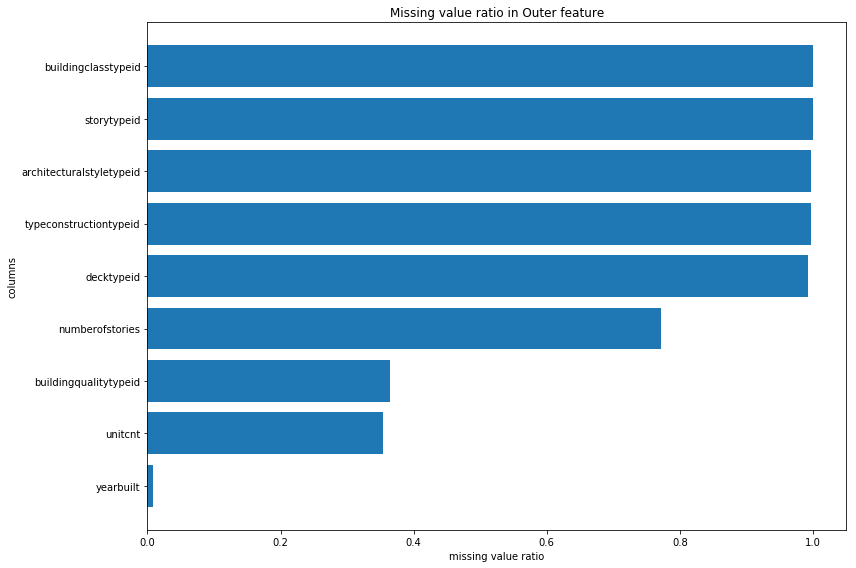

In [18]:
plt.figure(figsize=(12,8))
plt.barh(missing_outer_df.col,missing_outer_df.missing_ratio)
plt.title('Missing value ratio in Outer feature')
plt.xlabel('missing value ratio')
plt.ylabel('columns')
plt.tight_layout()
plt.show()

## 2.1) Fill the Missing data

In [19]:
missing_outer_df

,col,missing_cnt,missing_ratio
0,yearbuilt,756,0.008374
1,unitcnt,31922,0.353608
2,buildingqualitytypeid,32911,0.364564
3,numberofstories,69705,0.772141
4,decktypeid,89617,0.992711
5,typeconstructiontypeid,89976,0.996688
6,architecturalstyletypeid,90014,0.997109
7,storytypeid,90232,0.999524
8,buildingclasstypeid,90259,0.999823


- 위의 missing_ratio를 보면 6개의 컬럼이 NaN값의 비율이 99%가 넘는다. 이는 두 가지 이유로 나눠질 수 있다.
    - 0을 의미 -> 0으로 filling
    - 기록이 누락되었음, 그냥 없는 데이터를 의미 -> deleting columns
- missing_data에 대해서 delete가 아닌 filling을 선택할 때의 경우의 수
    - mean imputation : continous data
    - mode imputation : discrete data(categorical)
    - 'None' or '0' imputation : missing_data means zero in quantitative or qualitative prospect. 

#### yearbuilt : 0.8%
- Description:  주거지가 지어진 해
- Process: 카테고리가 130개로 매우 많지만, 년도를 나타내는 discrete data이기 때문에, mode 값으로 fill the miss한다.

In [20]:
train_df.yearbuilt = train_df.yearbuilt.fillna(train_df.yearbuilt.mode()[0])

In [21]:
train_df.yearbuilt.describe()

count    90275.000000
mean      1968.419540
std         23.695875
min       1885.000000
25%       1953.000000
50%       1969.000000
75%       1987.000000
max       2015.000000
Name: yearbuilt, dtype: float64

In [22]:
train_df.yearbuilt.value_counts().sort_values().tail()

1964.0    1919
1954.0    1940
1950.0    1994
1989.0    2058
1955.0    3017
Name: yearbuilt, dtype: int64

In [23]:
len(train_df.yearbuilt.value_counts())

130

#### unitcnt 35%
- Description: 구조가 구축 된 단위 수 (예 : 2 = 이중, 3 = 삼중 등)
- Process: 1중 구조가 가장 많으므로 이러한 구조가 일반적(common)인 것임을 알 수 있다.

In [24]:
train_df.unitcnt = train_df.unitcnt.fillna(train_df.unitcnt.mode()[0])

In [25]:
train_df.unitcnt.describe()

count    90275.000000
mean         1.071371
std          0.643133
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max        143.000000
Name: unitcnt, dtype: float64

In [26]:
train_df.unitcnt.value_counts()

1.0      86425
2.0       2354
4.0        871
3.0        619
6.0          1
5.0          1
9.0          1
11.0         1
143.0        1
70.0         1
Name: unitcnt, dtype: int64

In [27]:
len(train_df.unitcnt.value_counts())

10

#### buildingqualitytypeid : 36%
- Description: 건물 상태에 대한 평가 (최고부터 최악까지 평가가 매겨져 있다.)
- Process: 7점이 가장 많지만, 상태에 대한 평가이기 때문에, 평균값인 5점으로 filling 한다.

In [28]:
train_df.buildingqualitytypeid = train_df.buildingqualitytypeid.fillna(train_df.buildingqualitytypeid.mean())

In [29]:
train_df.buildingqualitytypeid.describe()

count    90275.000000
mean         5.565407
std          1.515046
min          1.000000
25%          4.000000
50%          5.565407
75%          7.000000
max         12.000000
Name: buildingqualitytypeid, dtype: float64

In [30]:
train_df.buildingqualitytypeid.value_counts()

5.565407     32911
7.000000     29310
4.000000     23839
1.000000      2627
10.000000     1461
12.000000      119
8.000000         5
6.000000         2
11.000000        1
Name: buildingqualitytypeid, dtype: int64

In [31]:
len(train_df.buildingqualitytypeid.value_counts())

9

#### numberofstories 77.2%
- Description: 집의 층 수 (story or level이라고 표현한다.)
- Process: 집의 층 수가 몇 개인지에 대한 컬럼이다. 주로 1층과 2층집이 많은 것을 감안해 mode값을 넣어준다.

In [32]:
train_df.numberofstories = train_df.numberofstories.fillna(train_df.numberofstories.mode()[0])

In [33]:
train_df.numberofstories.describe()

count    90275.000000
mean         1.100426
std          0.318951
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Name: numberofstories, dtype: float64

In [34]:
train_df.numberofstories.value_counts()

1.0    81721
2.0     8044
3.0      508
4.0        2
Name: numberofstories, dtype: int64

In [35]:
len(train_df.numberofstories.value_counts())

4

- 앞으로 나올 컬럼들은 결손값들이 99% 이상인 컬럼들이다.
    - 데이터가 누락된 것이다.
    - 0을 의미하는 값들이다.

#### typeconstructiontypeid 99.6%
- Description: census tract와 블록 ID 결합 - 또한 확장에 의한 블록 그룹 할당 포함
- Process: typeID에는 0번이 없다(1~18). 가지고 있는 데이터가 대표성을 지니고 있지 않으므로 None을 채워준다.

In [36]:
train_df.typeconstructiontypeid = train_df.typeconstructiontypeid.fillna('None')

In [37]:
train_df.typeconstructiontypeid.describe()

count     90275
unique        4
top        None
freq      89976
Name: typeconstructiontypeid, dtype: object

In [38]:
train_df.typeconstructiontypeid.value_counts()

None    89976
6.0       296
4.0         2
13.0        1
Name: typeconstructiontypeid, dtype: int64

In [39]:
len(train_df.typeconstructiontypeid.value_counts())

4

In [40]:
train_df.typeconstructiontypeid = train_df.typeconstructiontypeid.astype('object')

#### architecturalstyletypeid 99.7%
- Description: 건축 양식 아이디
- Process: 위의 컬럼과 마찬가지로 0번 ID는 존재하지 않는다. (1~27) 7번 ID가 가장많지만 missing_value가 너무 많아, 대표성을 지니지 못한다. None 값을 채워준다.

In [41]:
train_df.architecturalstyletypeid = train_df.architecturalstyletypeid.fillna('None')

In [42]:
train_df.architecturalstyletypeid.describe()

count     90275
unique        7
top        None
freq      90014
Name: architecturalstyletypeid, dtype: object

In [43]:
train_df.architecturalstyletypeid.value_counts()

None    90014
7.0       221
8.0        16
2.0        11
21.0        8
3.0         4
10.0        1
Name: architecturalstyletypeid, dtype: int64

In [44]:
len(train_df.architecturalstyletypeid.value_counts())

7

In [45]:
train_df.architecturalstyletypeid = train_df.architecturalstyletypeid.astype('object')

#### storytypeid
- Description: 집의 층 수 (story or level이라고 표현한다.)
- Process: 집의 층수를 나타내는 컬럼인데, 7의 데이터밖에 없어 대표성을 가지지 못한다. None값으로 채워준다.

In [46]:
train_df.storytypeid = train_df.storytypeid.fillna('None')

In [47]:
train_df.storytypeid.describe()

count     90275
unique        2
top        None
freq      90232
Name: storytypeid, dtype: object

In [48]:
train_df.storytypeid.value_counts().sort_values().tail()

7.0        43
None    90232
Name: storytypeid, dtype: int64

In [49]:
len(train_df.storytypeid.value_counts())

2

In [50]:
train_df.storytypeid = train_df.storytypeid.astype('object')

#### buildingclasstypeid
- Description: 건물 뼈대에 어떤 타입의 재료가 쓰였는지
- Process: TypeID는 건물 뼈대에 따라 1~5의 ID를 가지는데 4를 최빈값으로 가지지만, 대표성을 지니지 못한다.None으로 채워준다.

In [51]:
train_df.buildingclasstypeid = train_df.buildingclasstypeid.fillna('None')

In [52]:
train_df.buildingclasstypeid.describe()

count     90275
unique        2
top        None
freq      90259
Name: buildingclasstypeid, dtype: object

In [53]:
train_df.buildingclasstypeid.value_counts().sort_values().tail()

4.0        16
None    90259
Name: buildingclasstypeid, dtype: int64

In [54]:
len(train_df.buildingclasstypeid.value_counts())

2

In [55]:
train_df.buildingclasstypeid = train_df.buildingclasstypeid.astype('object')

#### decktypeID : 89.61%
- Description: 집 마당 부근에 있는 갑판(테라스와 유사)
- Process: 컬럼의 이름에서 명시하다시피 typeID에 관한 컬럼이다. 66 typeID가 최빈값으로 존재하지만, 대표성을 가지지 못한다. None으로 채워준다.

In [56]:
train_df.decktypeid = train_df.decktypeid.fillna('None')

In [57]:
train_df.decktypeid.describe()

count     90275
unique        2
top        None
freq      89617
Name: decktypeid, dtype: object

In [58]:
train_df.decktypeid.value_counts().sort_values().tail()

66.0      658
None    89617
Name: decktypeid, dtype: int64

In [59]:
len(train_df.decktypeid.value_counts())

2

In [60]:
train_df.decktypeid = train_df.decktypeid.astype('object')

## Feature Correlation
- 종속 변수 y vs 독립 변수 x
    - correlation barh plot
- 독립 변수 x vs 독립 변수 x
    - heatmap

In [62]:
numerical_features = [col for col in outer_feature_col if train_df[col].dtypes != 'object']
categorical_features = [col for col in outer_feature_col if train_df[col].dtypes == 'object']
len(numerical_features),len(categorical_features)

(4, 5)

### Numerical columns VS Logerror  Correlation plot

In [63]:
correl_val = []
for col in numerical_features:
    correl_val.append(np.corrcoef(train_df['logerror'],train_df[col])[0][1])
len(correl_val)

4

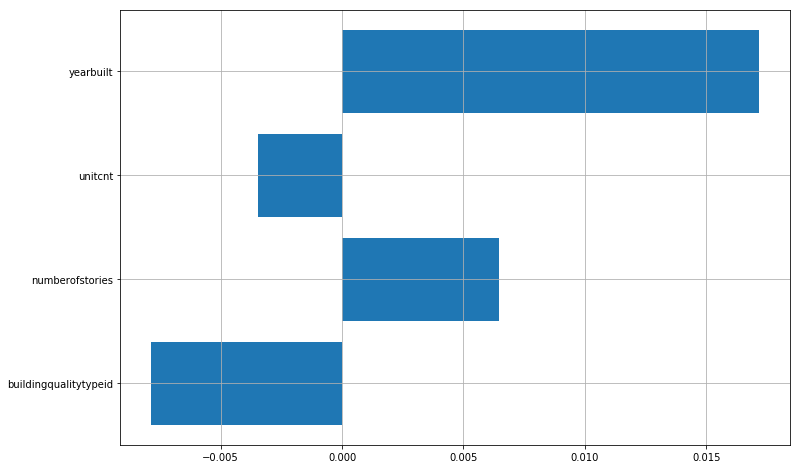

In [64]:
plt.figure(figsize=(12,8))
plt.grid(True)
plt.barh(numerical_features,correl_val)
plt.show()

## Columns vs Columns heatmap

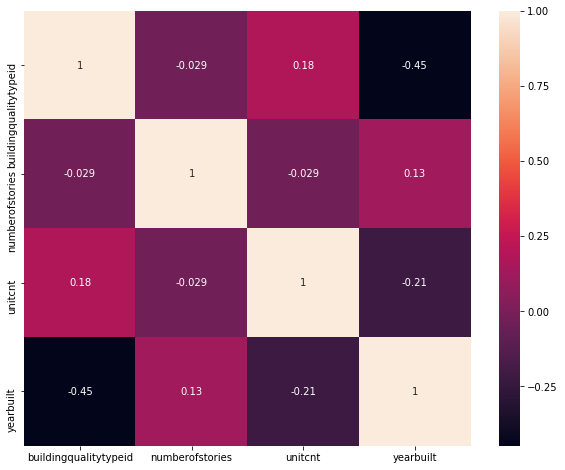

In [65]:
corrmat = train_df[numerical_features].corr(method = 'spearman')
plt.figure(figsize=(10,8))
sns.heatmap(corrmat,annot=True)
plt.show()